<a href="https://colab.research.google.com/github/kirank981/Project_space/blob/main/project_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tested linkage with github

Now familarizing with flower architecture and its flow of work, to do that Ill be training a simple convolutional neural network (CNN) on CIFAR-10 dataset.


In [11]:
# Preparations

# installing packages of flower, Pytorch
!pip install -q flwr[simulation] torch torchvision matplotlib
#importing libraries
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics
# acknowledgement of cpu/gpu usage,pytorch version and flower version
DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)


Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


In [12]:
# Loading data

# training convolutional neural network (CNN) on CIFAR-10 dataset.
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

# setting 10 clients
NUM_CLIENTS = 10

# segregating the dataset to training, validation and testing dataset and also splitting it between the 10 clients
BATCH_SIZE = 32

def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into training and validation sets and creating DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))

        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified


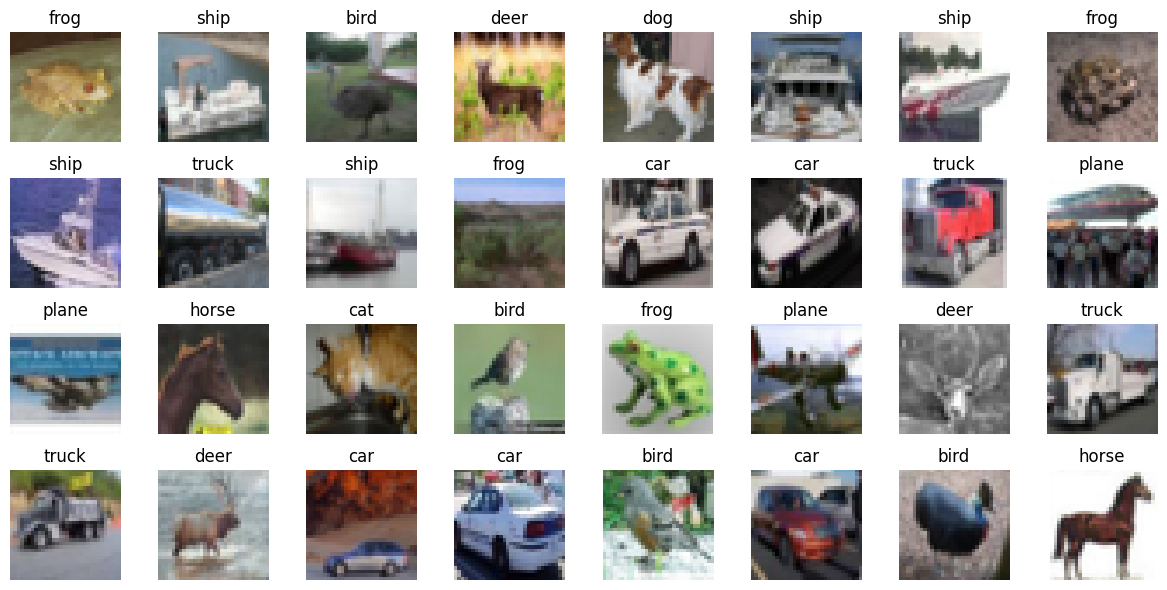

In [13]:
# first batch of images and labels in the first training set
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

In [14]:
# Centralized training

# using CCN Model to train the dataset
# CNN defined in pytorch website tutorial
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# creating training and testing functions
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# training the model
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(10):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.06140785312652588, accuracy 0.282
Epoch 2: validation loss 0.055182206869125366, accuracy 0.334
Epoch 3: validation loss 0.05524035620689392, accuracy 0.358
Epoch 4: validation loss 0.05324932456016541, accuracy 0.37
Epoch 5: validation loss 0.05163853168487549, accuracy 0.402
Epoch 6: validation loss 0.049832396507263184, accuracy 0.408
Epoch 7: validation loss 0.04990782880783081, accuracy 0.448
Epoch 8: validation loss 0.05001505637168884, accuracy 0.42
Epoch 9: validation loss 0.05161911654472351, accuracy 0.422
Epoch 10: validation loss 0.04793288278579712, accuracy 0.444
Final test set performance:
	loss 0.04566085915565491
	accuracy 0.474


In [15]:
# Federated learning

# Updating model parameters
# two helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local model: set_parameters and get_parameters.
# using "state_dict" to access PyTorch model parameter tensors, the parameter tensors are then converted to/from a list of NumPy ndarray’s (which Flower knows how to serialize/deserialize).
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [16]:
# Implementing a Flower client
# To implement the Flower client, we create a subclass of flwr.client.NumPyClient(for ease) and implement the three methods get_parameters, fit, and evaluate.
# class FlowerClient defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through fit and evaluate, each client will be represented by its own instance of FlowerClient.
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

# get_parameters: Return the current local model parameters
    def get_parameters(self, config):
        return get_parameters(self.net)

# fit: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

# evaluate: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server
    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [17]:
# Using Virtual client einge in Flower

# Implementing a function called client_fn that creates a FlowerClient instance on demand.
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [20]:
# Training the dataset in federated fashion

# The fn start_simulation accepts a no of arguments, including the client_fn (used to create FlowerClient instances), num_clients (the no of clients to simulate), num_rounds (the no of federated learning rounds), and the strategy.
# The strategy encapsulates the federated learning approach/algorithm, here-Federated Averaging (FedAvg). Here, the built-in FedAvg of flower, is used.

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)


INFO flwr 2023-07-18 10:28:19,721 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-07-18 10:28:27,762	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-18 10:28:30,067 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3962648985.0, 'memory': 7925297972.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3962648985.0, 'memory': 7925297972.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-07-18 10:28:30,072 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-18 10:28:30,074 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=36364) 2023-07-18 10:28:33.871789: W tensorflow/compiler/

History (loss, distributed):
	round 1: 0.06360524568557739
	round 2: 0.05706395034790039
	round 3: 0.05241459574699402
	round 4: 0.05043988466262818
	round 5: 0.048375154542922974

In [19]:
# to tell the framework how to handle/aggregate the custom metrics(like generic metrics dictionary (the one with the accuracy key)), metric aggregation functions are passed to the strategy.

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-07-18 10:20:26,669 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-07-18 10:20:30,914	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-18 10:20:34,576 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 7802988135.0, 'object_store_memory': 3901494067.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 7802988135.0, 'object_store_memory': 3901494067.0, 'CPU': 2.0}
INFO flwr 2023-07-18 10:20:34,581 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-18 10:20:34,596 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=34055) 2023-07-18 10:20:39.640216: W tensorflow/compiler/

History (loss, distributed):
	round 1: 0.06513766961097717
	round 2: 0.05487389974594117
	round 3: 0.05243136329650879
	round 4: 0.04995606026649475
	round 5: 0.04864257159233094
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.28400000000000003), (2, 0.3612), (3, 0.39399999999999996), (4, 0.4192), (5, 0.442)]}